# Fuel Performance

**Inputs**

- `fuel_dens`: Fuel density ($\frac{kg}{m^3}$)
- `porosity`: Porosity 
- `clad_thick`: Cladding thickness ($m$)
- `pellet_OD`: Pellet outer diameter ($m$)
- `pellet_h`: Pellet height ($m$)
- `gap_thick`: Gap thickness ($m$)
- `inlet_T`: Inlet temperature ($K$)
- `enrich`: U-235 enrichment
- `rough_fuel`: Fuel roughness ($m$)
- `rough_clad`: Clad roughness ($m$)
- `ax_pow`: Axial power
- `clad_T`: Cladding surface temperature ($K$)
- `pressure`: Pressure ($Pa$)

**Outputs**

- `fis_gas_produced`: Fission gas production ($mol$)
- `max_fuel_centerline_temp`: Max fuel centerline temperature ($K$)
- `max_fuel_surface_temp`: Max fuel surface temperature ($K$)
- `radial_clad_dia`: Radial cladding diameter displacement after irradiation ($m$)

This data set comprises 13 inputs and four outputs with 400 data points. This data originates from [[RK20]](https://pymaise.readthedocs.io/en/stable/index.html#id3), and a graphical representation is provided in the figure below. Case 1 from the pellet-cladding mechanical interaction (PCMI) benchmark was selected for the data set. This benchmark simulates a beginning of life (BOL) ramp of a 10-pellet pressurized water reactor (PWR) fuel rod to an average linear heat rate of $40~kW/m$. The inner and outer cladding diameters are reduced, so the fuel-clad interaction occurs during the ramp time. Axial power and rod surface temperature profiles were assumed to be uniform at $330^\circ C$. The 13 input parameters were uniformly randomly sampled independently within their uncertainty bounds and simulated in BISON. The rod response was recorded in 4 outputs.

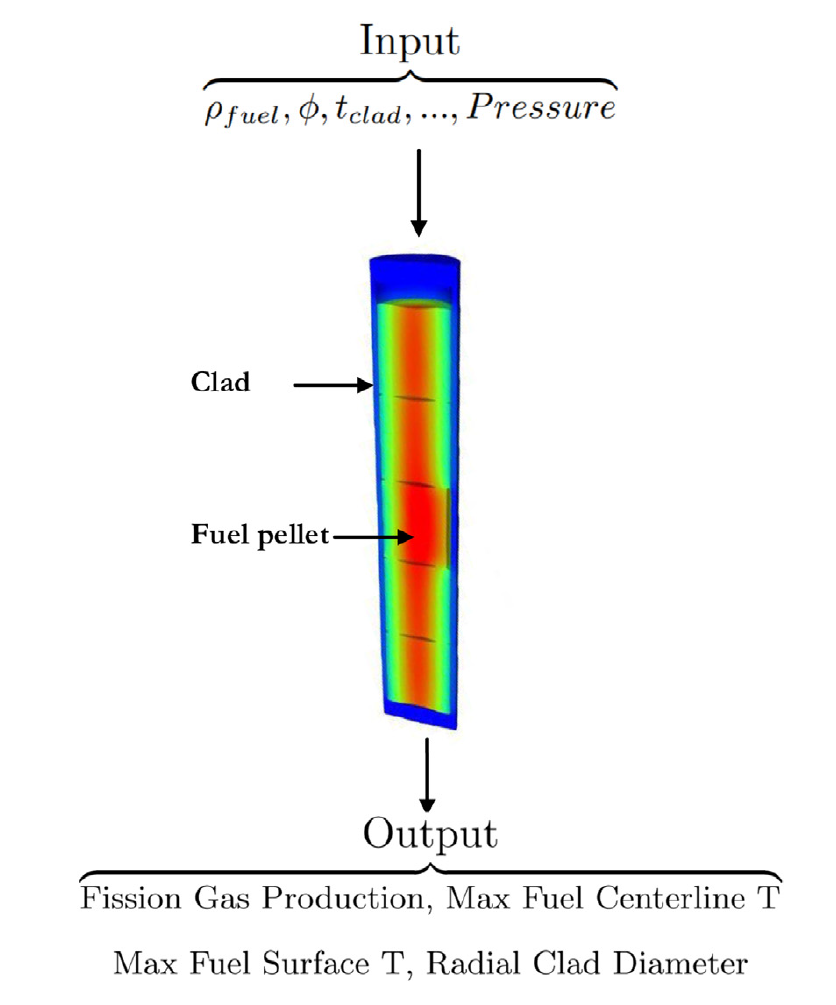


The following are a few common packages and functions that will prove useful while using pyMAISE along with pyMAISE-specific functionality. 

In [1]:
# Importing Packages
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# pyMAISE specific imports
import pyMAISE as mai
from pyMAISE.datasets import load_fp
from pyMAISE.preprocessing import scale_data, train_test_split, correlation_matrix

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 11,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

## pyMAISE Initialization

We start by initializing pyMAISE settings and then importing the data set using `pyMAISE.datasets.load_fp()` from the pyMAISE dataset library.

In [2]:
# Constructing pyMAISE settings
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)

# Get data
data, inputs, outputs = load_fp()

As stated the data set consists of 13 inputs:

In [3]:
inputs

<xarray.DataArray (index: 400, variable: 13)>
array([[1.0466e+04, 4.0527e-02, 5.7110e-04, ..., 9.9967e-01, 6.0272e+02,
        1.5504e+07],
       [1.0488e+04, 4.1780e-02, 5.6984e-04, ..., 9.8741e-01, 6.0281e+02,
        1.5591e+07],
       [1.0434e+04, 5.8323e-02, 5.6760e-04, ..., 9.9225e-01, 6.2033e+02,
        1.5510e+07],
       ...,
       [1.0474e+04, 4.9933e-02, 5.6787e-04, ..., 9.7834e-01, 5.9643e+02,
        1.5645e+07],
       [1.0456e+04, 4.4766e-02, 5.7574e-04, ..., 9.5912e-01, 5.9159e+02,
        1.5441e+07],
       [1.0438e+04, 5.5806e-02, 5.7198e-04, ..., 9.9917e-01, 6.0763e+02,
        1.5379e+07]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 392 393 394 395 396 397 398 399
  * variable  (variable) object 'fuel_dens' 'porosity' ... 'clad_T' 'pressure'

and 4 outputs with 400 total data points:

In [4]:
outputs

<xarray.DataArray (index: 400, variable: 4)>
array([[2.95000000e-05, 1.56969931e+03, 6.99613033e+02, 1.88000000e-05],
       [3.17000000e-05, 1.55946516e+03, 6.99976191e+02, 1.87000000e-05],
       [3.11000000e-05, 1.63239410e+03, 7.12771506e+02, 2.02000000e-05],
       ...,
       [3.04000000e-05, 1.55122859e+03, 6.92270857e+02, 1.81000000e-05],
       [3.09000000e-05, 1.50301759e+03, 6.83481715e+02, 1.72000000e-05],
       [3.17000000e-05, 1.62006353e+03, 7.04130846e+02, 1.98000000e-05]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 392 393 394 395 396 397 398 399
  * variable  (variable) object 'fis_gas_produced' ... 'radial_clad_dia'

Prior to constructing any models we can get a surface understanding of the data set with a correlation matrix.

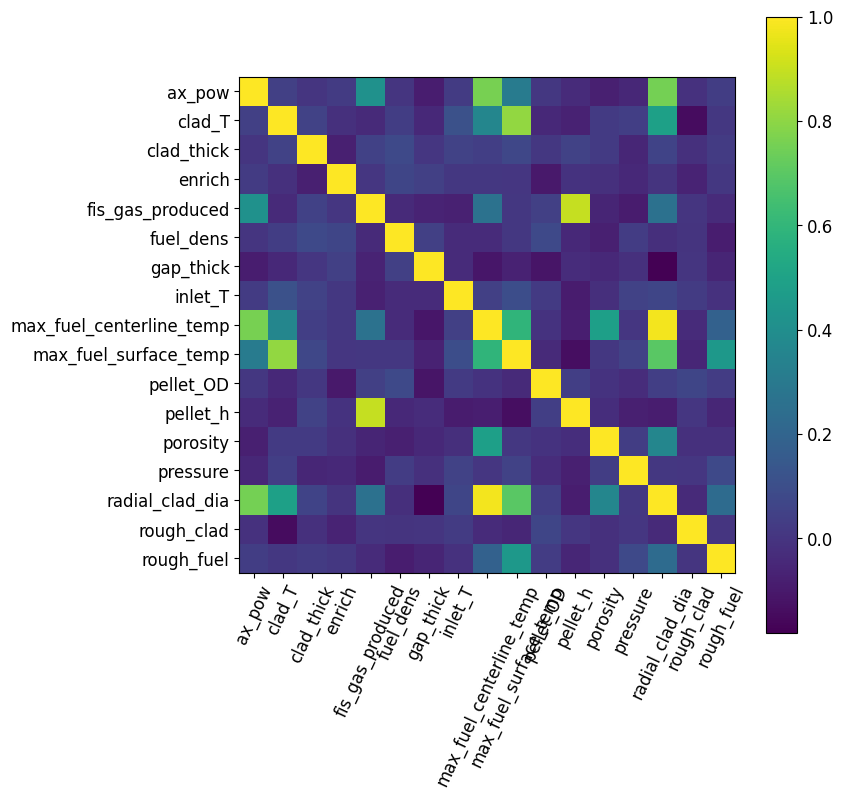

In [5]:
correlation_matrix(data)
plt.show()

A positive correlation exists between axial power and cladding temperature with max fuel centerline temperature, max fuel surface temperature, and radial cladding diameter. Additionally, the fission gas production correlates with pellet height.

The final step of the pyMAISE processing is splitting and data scaling. For this data set, we will use min-max scaling.

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(data=[inputs, outputs], test_size=0.3)
xtrain, xtest, xscaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

## Model Initialization

We will examine the performance of six models in this data set:

- Linear regression: `Linear`,
- Lasso regression: `Lasso`,
- Decision tree regression: `DT`,
- Random forest regression: `RF`,
- K-nearest neighbors regression: `KN`,
- Sequential dense neural networks: `FNN`.

For hyper-parameter tuning each model, we must initialize the architecture and optimize search spaces.

In [7]:
# Initializing all the models wanted along with neurel network archetecture/optimization hps
model_settings = {
    "models": ["Linear", "Lasso", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=2),
                "units": mai.Int(min_value=25, max_value=400),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.2, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32]),
            "epochs": 50,
            "validation_split": 0.15,
        },
    },
}
# Constructing Tuner object for the search space above
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

## Hyperparameter Tuning

We will use random search for the hyperparameter tuning of the classical models (`Lasso`, `DT`, `RF`, and `KN`) through the `pyMAISE.Tuner.random_search` function. `Linear` will be manually fit with the Scikit-learn defaults. Three hundred models will be produced with randomly sampled parameter configurations for each classical model. For `FNN`, Bayesian search optimizes the hyper-parameters in 50 iterations through the `pyMAISE.Tuner.nn_bayesian_search` function. Bayesian search is appealing for `FNN`s as their training can be computationally expensive. To further reduce the computational cost of `FNN`, we specify only 10 epochs, which will produce less than performant models but show the optimal parameters. For both search methods, we use cross-validation to reduce bias in the models from the data set. The `random_search_spaces` and `bayesian_search_spaces` dictionaries define the hyperparameter search spaces.

In [8]:
# Classical Model search space
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}

start = time.time()
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=300,
    n_jobs=6,
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=50,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Hyperparameter tuning took 18.3358749071757 minutes to process.


We can understand the hyperparameter tuning of Bayesian search from the convergence plot.

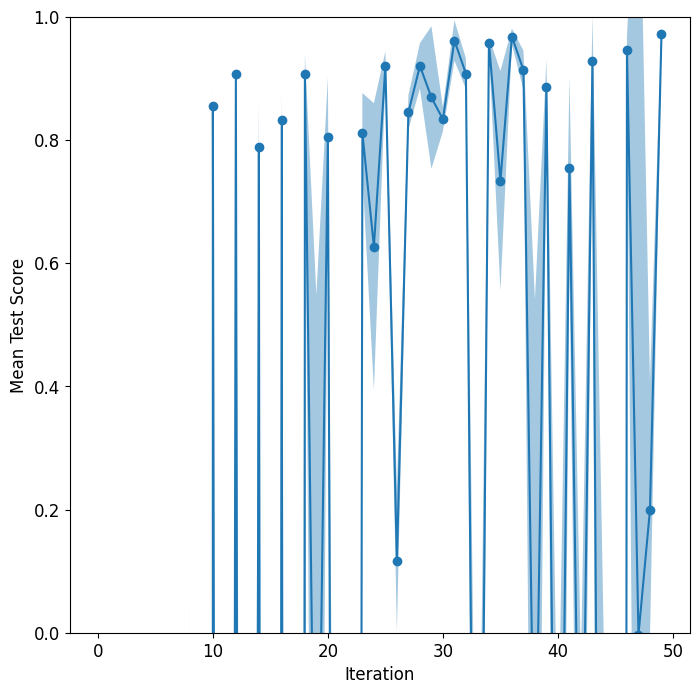

In [9]:
ax = tuner.convergence_plot(model_types="FNN")
ax.set_ylim([0, 1])
plt.show()

## Model Postprocessing

Now that the top `pyMAISE.Settings.num_configs_saved` is saved, we can pass these models to the `pyMAISE.PostProcessor` for model comparison and analysis. We can pass an updated epoch parameter to improve the `FNN` performance. Using 200 epochs should improve fitting at a higher computational cost.

In [10]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[random_search_configs, bayesian_search_configs], 
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 200}},
    },
    yscaler=yscaler,
)

To compare the performance of these models, we compute 5 regression metrics for both the training and testing data starting with `fis_gas_produced`.

In [11]:
postprocessor.metrics(y="fis_gas_produced").drop("Parameter Configurations", axis=1)

,Model Types,Train R2,Train MAE,Train MAPE,Train RMSE,Train RMSPE,Test R2,Test MAE,Test MAPE,Test RMSE,Test RMSPE
1,Lasso,0.999249,3.267837e-08,0.105070,4.030055e-08,0.128619,0.999136,3.559040e-08,0.113771,4.484320e-08,0.143256
2,Lasso,0.999239,3.275665e-08,0.105269,4.054609e-08,0.129238,0.999130,3.571272e-08,0.114105,4.499994e-08,0.143612
3,Lasso,0.999227,3.288416e-08,0.105612,4.088874e-08,0.130128,0.999121,3.591126e-08,0.114679,4.523315e-08,0.144175
4,Lasso,0.999220,3.295873e-08,0.105818,4.107072e-08,0.130610,0.999116,3.603471e-08,0.115045,4.536235e-08,0.144499
0,Linear,0.999310,3.168910e-08,0.102395,3.863014e-08,0.125121,0.999109,3.588714e-08,0.115257,4.553942e-08,0.146872
5,Lasso,0.999194,3.323912e-08,0.106585,4.174702e-08,0.132392,0.999093,3.655098e-08,0.116571,4.595885e-08,0.146066
24,FNN,0.999267,3.172853e-08,0.101532,3.980708e-08,0.126294,0.998852,4.219576e-08,0.134439,5.170993e-08,0.163768
23,FNN,0.999168,3.304269e-08,0.106213,4.239647e-08,0.136041,0.998710,3.968244e-08,0.128253,5.481314e-08,0.180527
22,FNN,0.999133,3.344044e-08,0.107452,4.328207e-08,0.138001,0.997890,5.162809e-08,0.164974,7.008479e-08,0.223606
25,FNN,0.996695,6.590440e-08,0.211386,8.452412e-08,0.269632,0.994295,9.165209e-08,0.296087,1.152505e-07,0.376203


Fission gas production is well modeled by linear regression, lasso regression, and the FNNs. Random forest, decision tree, and k-nearest neighbors overfit.

In [12]:
postprocessor.metrics(y="max_fuel_centerline_temp").drop("Parameter Configurations", axis=1)

,Model Types,Train R2,Train MAE,Train MAPE,Train RMSE,Train RMSPE,Test R2,Test MAE,Test MAPE,Test RMSE,Test RMSPE
23,FNN,0.998678,0.959041,0.060105,1.330949,0.083098,0.997927,1.436364,0.089821,1.807812,0.112611
0,Linear,0.996779,1.662797,0.104141,2.077207,0.129495,0.997002,1.810299,0.113178,2.173938,0.135721
24,FNN,0.997661,1.539107,0.096887,1.770200,0.111391,0.996961,1.851383,0.115759,2.188771,0.136523
1,Lasso,0.996630,1.690721,0.105876,2.124680,0.132083,0.996933,1.813756,0.113306,2.198835,0.136777
2,Lasso,0.996604,1.696770,0.106257,2.132958,0.132563,0.996909,1.814631,0.113346,2.207504,0.137240
3,Lasso,0.996572,1.703724,0.106697,2.142955,0.133146,0.996880,1.816079,0.113420,2.217844,0.137797
4,Lasso,0.996556,1.707566,0.106940,2.148073,0.133446,0.996865,1.818221,0.113543,2.223153,0.138085
5,Lasso,0.996483,1.723801,0.107968,2.170474,0.134775,0.996798,1.831387,0.114327,2.246755,0.139393
22,FNN,0.996662,1.831592,0.115049,2.114543,0.132727,0.995799,2.105146,0.131838,2.573576,0.161047
21,FNN,0.993056,2.852232,0.179368,3.050029,0.192006,0.991793,3.126996,0.196687,3.596870,0.226700


The max fuel centerline temperature follows the results for fission gas production.

In [13]:
postprocessor.metrics(y="max_fuel_surface_temp").drop("Parameter Configurations", axis=1)

,Model Types,Train R2,Train MAE,Train MAPE,Train RMSE,Train RMSPE,Test R2,Test MAE,Test MAPE,Test RMSE,Test RMSPE
24,FNN,0.970706,1.042259,0.148455,1.324400,0.188425,0.949714,1.470127,0.209119,1.740219,0.247463
25,FNN,0.973464,0.955344,0.136119,1.260509,0.179470,0.949016,1.387546,0.197722,1.752252,0.249905
22,FNN,0.974767,0.930137,0.132469,1.229161,0.174898,0.945756,1.434863,0.204155,1.807396,0.257244
21,FNN,0.986594,0.661442,0.094185,0.895940,0.127278,0.945250,1.397176,0.198757,1.815818,0.258065
23,FNN,0.972978,0.948672,0.135150,1.271987,0.181186,0.942465,1.511166,0.215032,1.861422,0.264730
5,Lasso,0.922228,1.885735,0.268292,2.157935,0.306437,0.922532,1.879137,0.266959,2.159933,0.306249
4,Lasso,0.922365,1.884122,0.268058,2.156028,0.306168,0.922468,1.877271,0.266691,2.160824,0.306384
3,Lasso,0.922397,1.883713,0.267999,2.155594,0.306107,0.922446,1.876793,0.266622,2.161123,0.306429
2,Lasso,0.922455,1.882881,0.267878,2.154784,0.305993,0.922396,1.875821,0.266482,2.161821,0.306533
1,Lasso,0.922496,1.882235,0.267784,2.154207,0.305912,0.922351,1.875050,0.266371,2.162459,0.306627


The max fuel surface temperature is the output with the worst results for all models. While the FNNs performed the best, they are slightly overfitting the testing data set for max fuel temperature.

In [14]:
postprocessor.metrics(y="radial_clad_dia").drop("Parameter Configurations", axis=1)

,Model Types,Train R2,Train MAE,Train MAPE,Train RMSE,Train RMSPE,Test R2,Test MAE,Test MAPE,Test RMSE,Test RMSPE
23,FNN,0.997719,3.087367e-08,0.160873,3.743942e-08,0.195272,0.997372,3.429735e-08,0.177476,4.359127e-08,0.225859
24,FNN,0.998063,2.744403e-08,0.143042,3.449764e-08,0.179363,0.997312,3.567847e-08,0.184711,4.408844e-08,0.228719
0,Linear,0.996885,3.386715e-08,0.176316,4.374572e-08,0.226314,0.996611,3.808067e-08,0.197759,4.950502e-08,0.257513
1,Lasso,0.996720,3.444509e-08,0.178714,4.488771e-08,0.230358,0.996450,3.930008e-08,0.203166,5.066126e-08,0.260430
2,Lasso,0.996687,3.457049e-08,0.179306,4.511660e-08,0.231355,0.996409,3.953350e-08,0.204256,5.095614e-08,0.261581
3,Lasso,0.996640,3.473036e-08,0.180062,4.543647e-08,0.232782,0.996351,3.983507e-08,0.205670,5.136442e-08,0.263219
4,Lasso,0.996615,3.481478e-08,0.180466,4.560650e-08,0.233552,0.996321,4.001523e-08,0.206525,5.157962e-08,0.264099
5,Lasso,0.996505,3.523930e-08,0.182561,4.633958e-08,0.236938,0.996190,4.075426e-08,0.210047,5.248848e-08,0.267895
22,FNN,0.996870,3.586296e-08,0.187303,4.385517e-08,0.229512,0.996110,4.328295e-08,0.225161,5.303164e-08,0.276731
25,FNN,0.994762,4.209612e-08,0.218408,5.672830e-08,0.293930,0.993466,5.597111e-08,0.290642,6.873258e-08,0.359265


Performance for radial cladding diameter follows the results of fission gas production and max fuel centerline temperature.

In [15]:
postprocessor.metrics().drop(
    ["Parameter Configurations", "Train MAE", "Test MAE", "Train RMSE", "Test RMSE"], 
    axis=1,
)

,Model Types,Train R2,Train MAPE,Train RMSPE,Test R2,Test MAPE,Test RMSPE
24,FNN,0.991424,0.122479,0.151368,0.985710,0.161007,0.194118
23,FNN,0.992136,0.115585,0.148899,0.984118,0.152645,0.195932
22,FNN,0.991858,0.135568,0.168784,0.983889,0.181532,0.229657
25,FNN,0.989424,0.177330,0.234118,0.981960,0.239294,0.305409
21,FNN,0.990602,0.255999,0.282946,0.980076,0.279947,0.334631
1,Lasso,0.978774,0.164361,0.199243,0.978718,0.174153,0.211772
2,Lasso,0.978746,0.164678,0.199787,0.978711,0.174547,0.212241
3,Lasso,0.978709,0.165092,0.200541,0.978700,0.175098,0.212905
4,Lasso,0.978689,0.165320,0.200944,0.978692,0.175451,0.213267
5,Lasso,0.978602,0.166352,0.202636,0.978653,0.176976,0.214901


The FNN performed the best, given its max fuel surface temperature performance. This was followed by linear and lasso regression. Random forest, decision tree, and k-nearest neighbors overfit.

We can see the parameters of each model with the best test $R^2$ with `pyMAISE.PostProcessor.get_params`.

In [16]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    postprocessor.print_model(model_type=model)
    print()

Model Type: Lasso
  alpha: 0.00011152849995783162

Model Type: DT
  max_depth: 19
  max_features: None
  min_samples_leaf: 4
  min_samples_split: 3

Model Type: RF
  criterion: poisson
  max_features: None
  min_samples_leaf: 1
  min_samples_split: 4
  n_estimators: 157

Model Type: KN
  leaf_size: 22
  n_neighbors: 6
  p: 3
  weights: distance

Model Type: FNN
  Structural Hyperparameters
    Layer: Dense_hidden_0
      units: 317
      sublayer: None
    Layer: Dense_output_0
  Compile/Fitting Hyperparameters
    Adam_learning_rate: 0.0008429771654396034
    batch_size: 16



We can visualize the performance of each model with diagonal validation plots. These plots show the predicted output to the actual output.

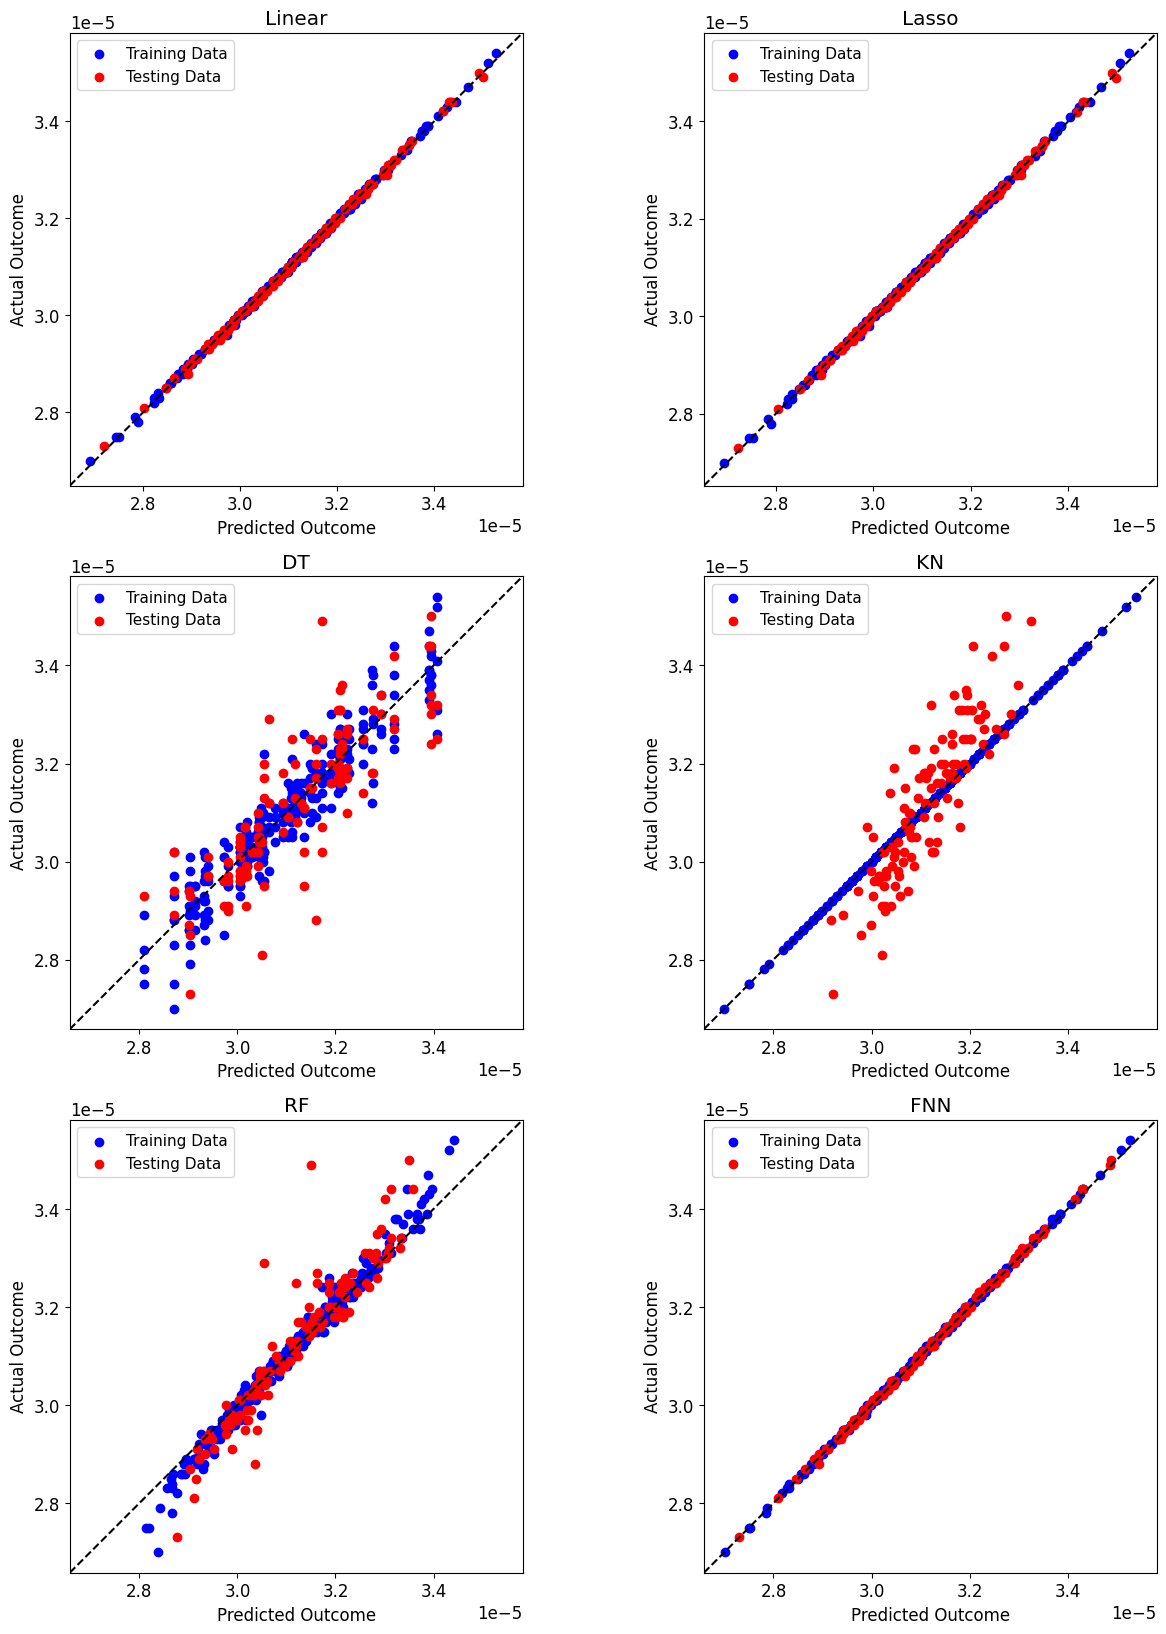

In [17]:
def performance_plot(meth, output):
    models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])
    fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(15,20))
    for i in range(models.shape[0]):
        for j in range(models.shape[1]):
            plt.sca(axarr[i, j])
            axarr[i, j] = meth(model_type=models[i, j], y=[output])
            axarr[i, j].set_title(models[i, j])


performance_plot(postprocessor.diagonal_validation_plot, "fis_gas_produced")
plt.show()

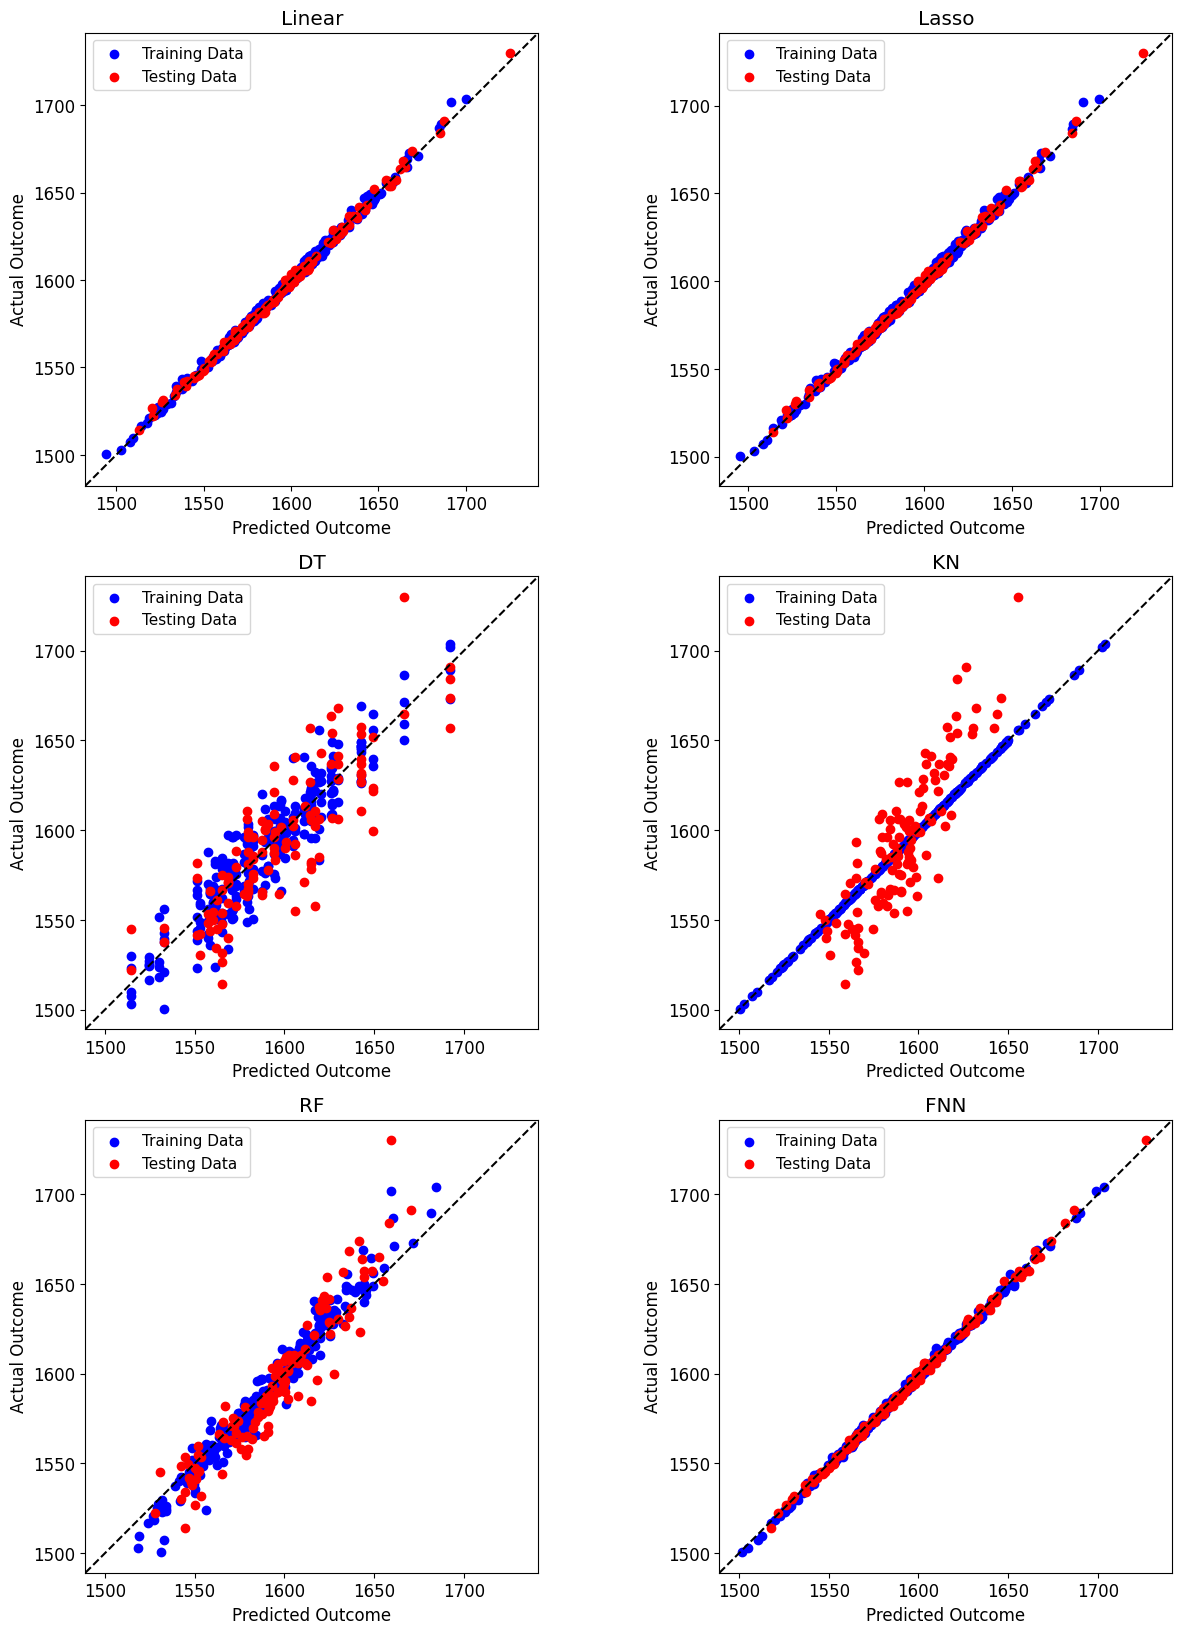

In [18]:
performance_plot(postprocessor.diagonal_validation_plot, "max_fuel_centerline_temp")
plt.show()

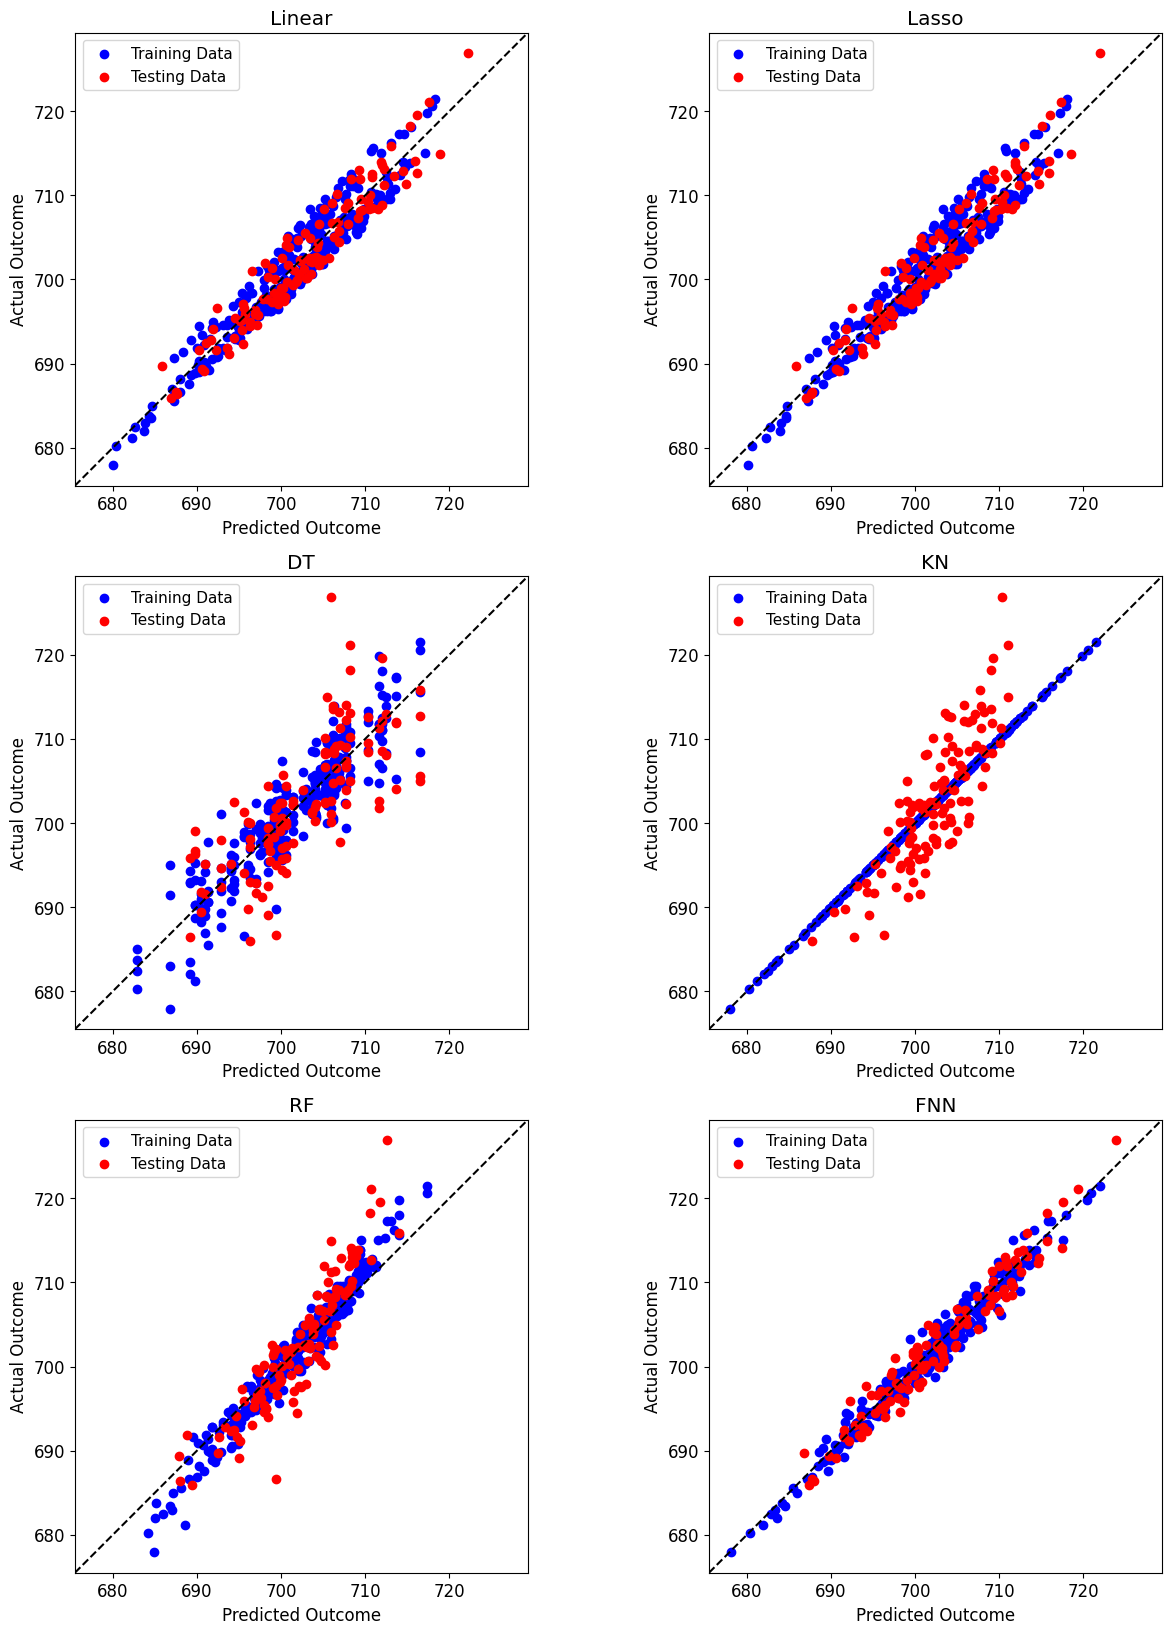

In [19]:
performance_plot(postprocessor.diagonal_validation_plot, "max_fuel_surface_temp")
plt.show()

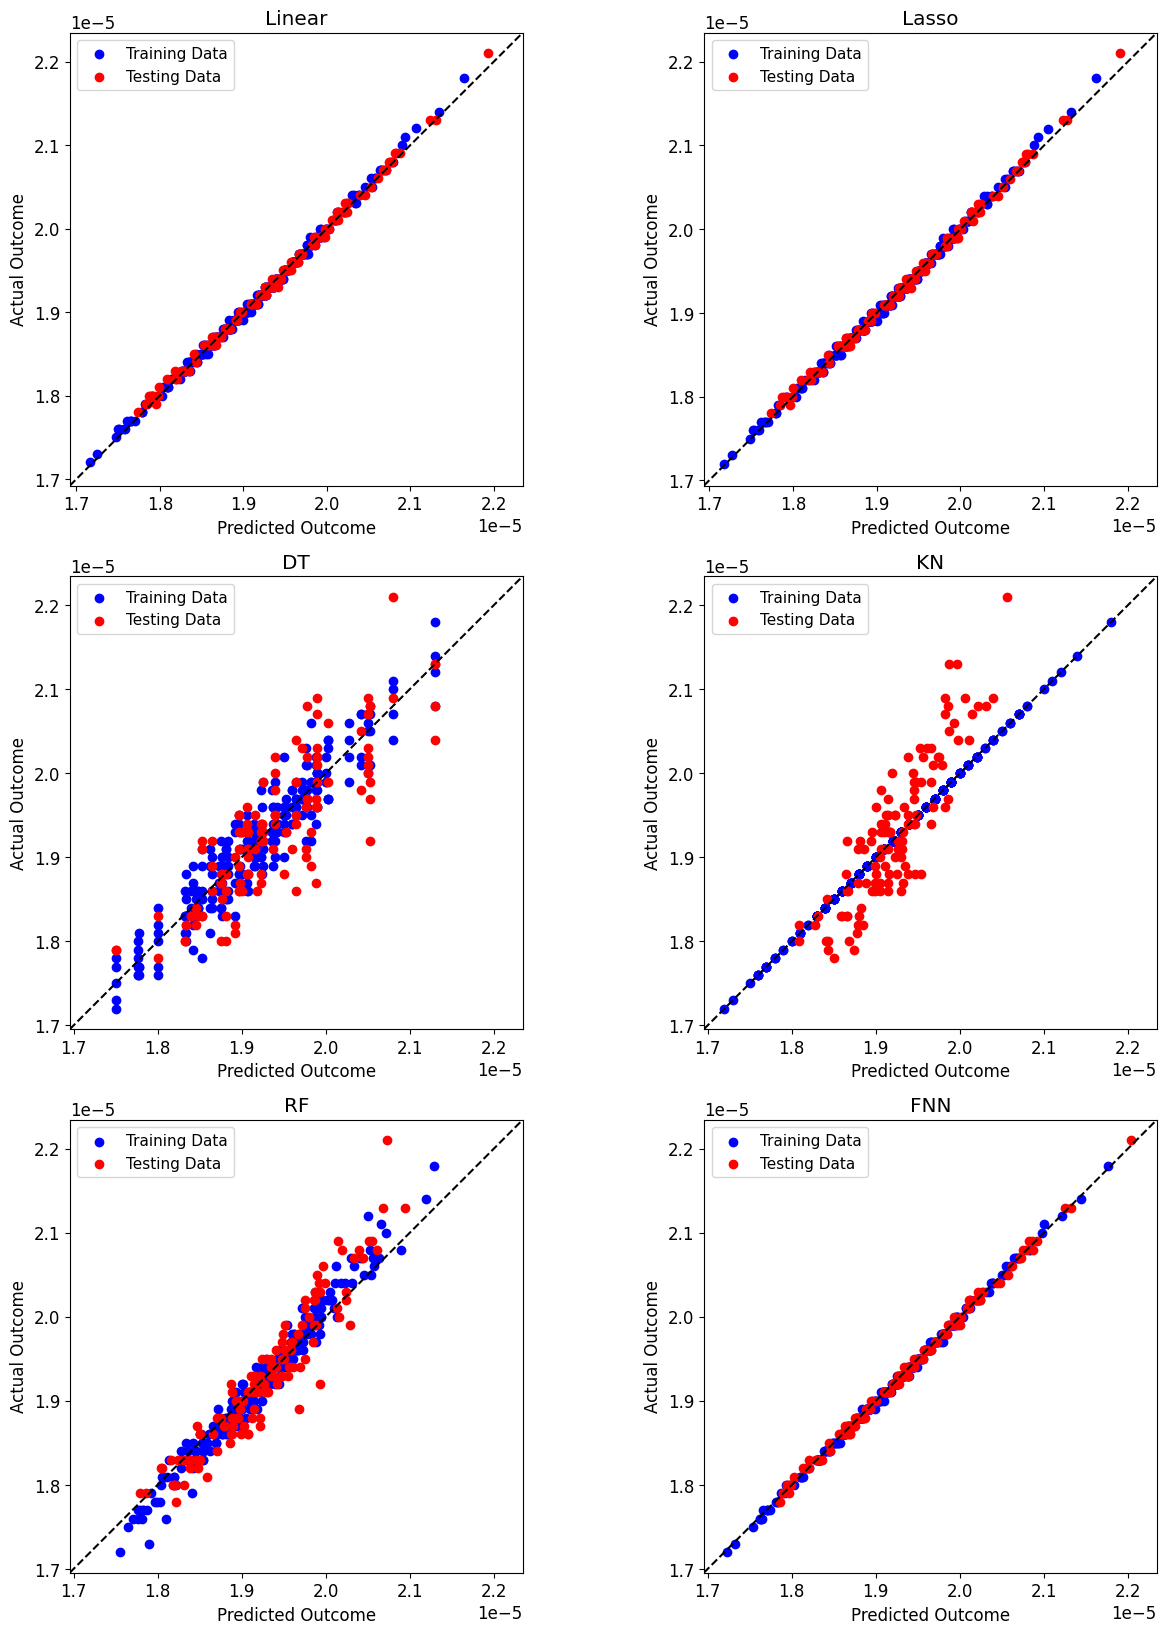

In [20]:
performance_plot(postprocessor.diagonal_validation_plot, "radial_clad_dia")
plt.show()

With these plots, we can see the narrow spread of `Linear`, `Lasso`, and `FNN` to $y = x$, the best possible performance of a model. Additionally, `KN` appears to be overfitted to the training data set, and the predictions of `FNN` under 700 K approximate the max fuel surface temperature. 

Similarly, the `pyMAISE.PostProcessor.validation_plot` function produces validation plots showing each output's absolute relative error.

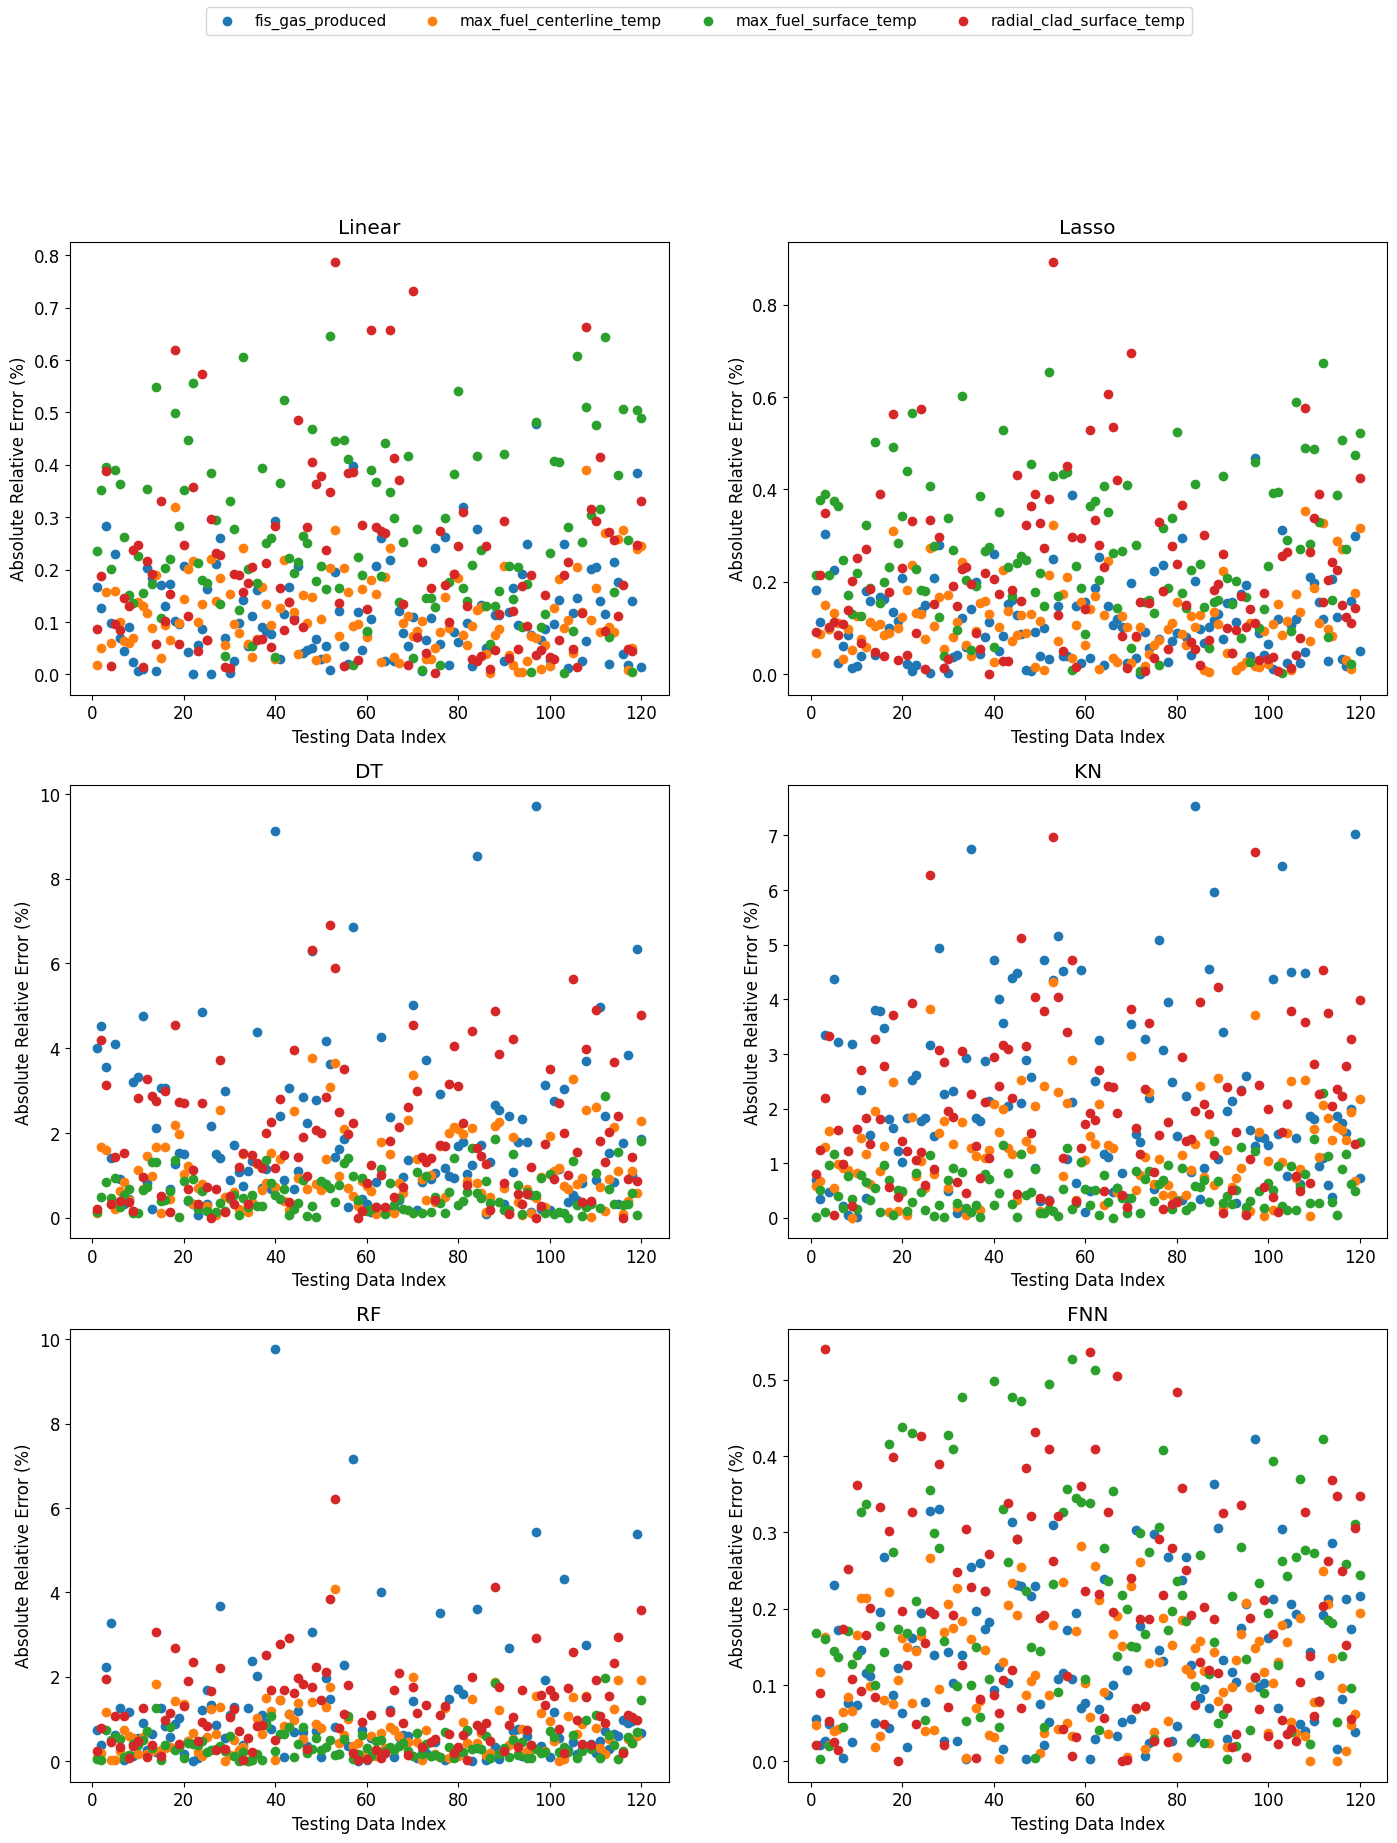

In [21]:
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])

fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(17,20))

for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.validation_plot(model_type=models[i, j])
        axarr[i, j].set_title(models[i, j])
        axarr[i, j].get_legend().remove()

fig.legend(
    ["fis_gas_produced", "max_fuel_centerline_temp", "max_fuel_surface_temp", "radial_clad_surface_temp"], 
    loc="upper center", 
    ncol=4
)
plt.show()

The performance gap between the linear model and the others is evident in the magnitude of the relative error.

Finally, the most performant `FNN` learning curve is shown by `pyMAISE.PostProcessor.nn_learning_plot`.

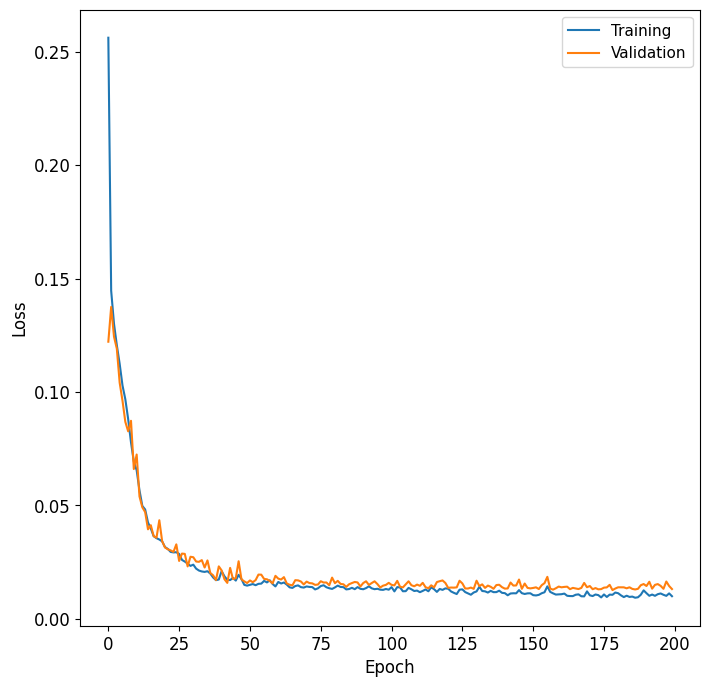

In [22]:
postprocessor.nn_learning_plot()
plt.show()

The validation curve is below the training curve; therefore, the best performing `FNN` is not overfit. 

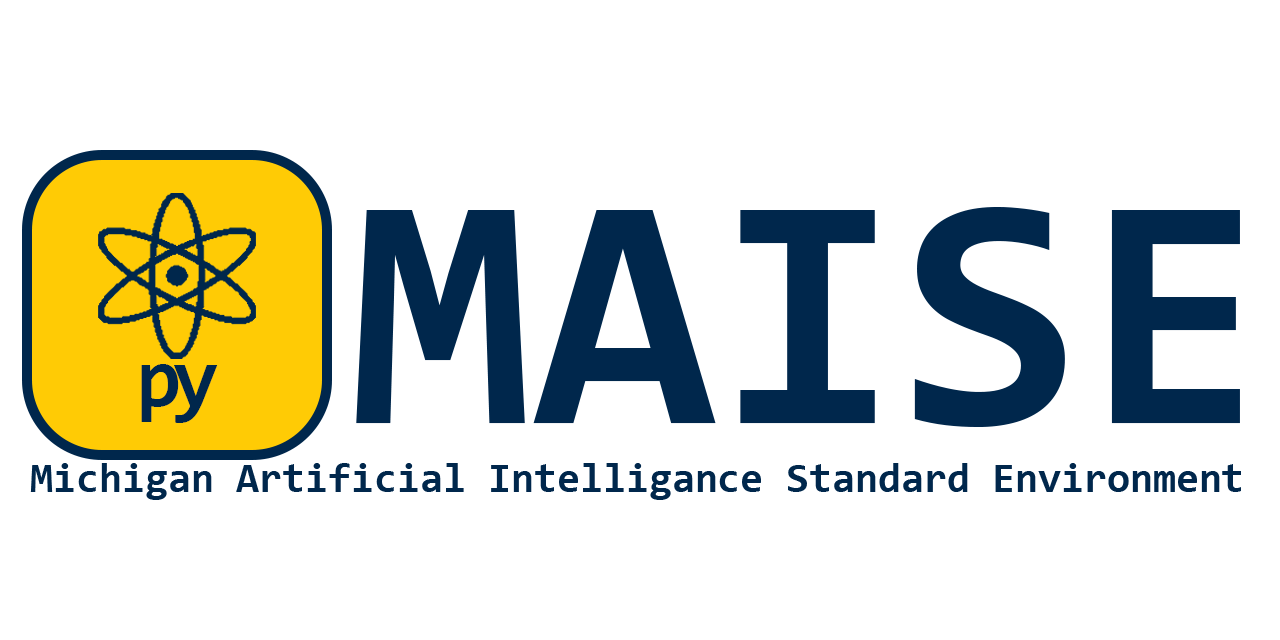